# Consumer Opt. with PV

In [1]:
using Pkg
Pkg.activate("."); 
Pkg.instantiate()

  Activating project at `C:\Users\ESchr\workspace\uni\ATIS3\Single_Project\ATIES3_single_project_ES`


In [2]:
using JuMP, LinearAlgebra, StatsPlots, Statistics, CSV, DataFrames, XLSX, CPLEX, AxisArrays

## Input handling

In [60]:
input_path = "input\\"
xl = XLSX.readxlsx(input_path * "input.xlsx") 
data = Dict()

for s in XLSX.sheetnames(xl)
    data[s] = DataFrame(XLSX.gettable(xl[s]; infer_eltypes=true)...)
end

## Create Axis-Arrays

In [61]:
#Sets
W_PP = data["pool_price_scenarios"][:, :Scenario]
W_NAM = data["non_anticipativity_matrix"][:, :Scenario]
B = data["bilateral_contract_data"][:, :Contract]
D = data["electricity_demand"][:, :Demand]
T = ["t1", "t2", "t3", "t4"]
K = ["k1", "k2", "k3", "k4"]
println("Sets created")

Sets created


In [62]:
#Axis arrays
Dpool_price_scenarios = Dict(c => AxisArray(data["pool_price_scenarios"][:, c], w_pp=W_PP) for c in names(data["pool_price_scenarios"]));
Dpool_price_scenarios["t1"]["w1"]

Dbilateral_contract_data = Dict(c => AxisArray(data["bilateral_contract_data"][:, c], b=B) for c in names(data["bilateral_contract_data"]));
Dbilateral_contract_data["price"]["b1"]

Delectricity_demand = Dict(c => AxisArray(data["electricity_demand"][:, c], d=D) for c in names(data["electricity_demand"]));
Delectricity_demand["t1"]["d1"]

Dnon_anticipativity_matrix = Dict(c => AxisArray(data["non_anticipativity_matrix"][:, c], w_nam=W_NAM) for c in names(data["non_anticipativity_matrix"]));
Dnon_anticipativity_matrix["k1"]["w1"]

Dpv_production = Dict(c => AxisArray(data["pv_production"][:, c], w_pp=W_PP) for c in names(data["pv_production"]));
Dpv_production["t1"]["w1"]
println("Axis Arrays created")

Axis Arrays created


In [198]:
# Risk
β = 0.5
α = 0.95

#Mapping of bilateral contracts active in period T
Bt = Dict()
for t in T
    temp = String[]
    for b in B
        if(Dbilateral_contract_data[t][b]==1)
            push!(temp, b)
        end
    end
    Bt[t] = temp
end 

#Mapping of decisions on bilateral contracts made in stage K
Kb = Dict()
Kb["k1"] = Bt["t1"]
Kb["k2"] = ["b4"]
Kb["k3"] = ["b5"]
Kb["k4"] = ["b6"]

#Probalitie for scenarios
prob = Dict()
for w in W_PP
    prob[w] = 1/length(W_PP)
end

#Arrays of decisions on bilateral contracts made in stage K
k1 = data["non_anticipativity_matrix"][:, :k1]
k2 = data["non_anticipativity_matrix"][:, :k2]
k3 = data["non_anticipativity_matrix"][:, :k3]
k4 = data["non_anticipativity_matrix"][:, :k4]

NW_PP = length(W_PP)

#Duration in hours of every period t
d = Dict()
for t in T
    d[t]=1
end

println("Sets created")

Sets created


In [199]:
co_pv = Model(CPLEX.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: CPLEX

In [200]:
@variables(co_pv, begin
        PB[B,W_PP]            #Power purchased from bilateral contracts
        s[B,W_PP], Bin        #Selection of bilateral contracts
        EP[T,W_PP]            #Energy traded in the pool
        η[W_PP] >= 0          #Auxiliary variable used to calculate the CVaR
        ζ                     #Auxiliary variable used to calculate the CVaR
    end)
println("Variables created")

Variables created


In [201]:
@time begin    
    λ_B = @expression(co_pv, [t in T, w in W_PP, b in Bt[t]], (Dpool_price_scenarios[t][w]+Dbilateral_contract_data["price"][b])/2)
    λ_P = @expression(co_pv, [t in T, w in W_PP], Dpool_price_scenarios[t][w])
    CVaR = @expression(co_pv, ζ+(1/(1-α))*sum(prob[w]*η[w] for w in W_PP))    
    z = @expression(co_pv, sum(prob[w] * sum(sum(λ_B[t,w,b] * PB[b,w] * d[t] for b in Bt[t]) 
                + λ_P[t,w] * EP[t,w] for t in T) for w in W_PP)
                    + β * CVaR)
end
println("Expressions created")

  0.438180 seconds (548.66 k allocations: 32.134 MiB, 10.15% gc time, 98.84% compilation time)
Expressions created


In [202]:
@constraints(co_pv, begin
        LimitContractMin[b in B, w in W_PP], PB[b,w] >= s[b,w] * Dbilateral_contract_data["min_power"][b]
        LimitContractMax[b in B, w in W_PP], PB[b,w] <= s[b,w] * Dbilateral_contract_data["max_power"][b]
        
        Non_Anticipativity1[b in Kb["k1"], τ in (1:NW_PP-1)[k1.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        Non_Anticipativity2[b in Kb["k2"], τ in (1:NW_PP-1)[k2.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        Non_Anticipativity3[b in Kb["k3"], τ in (1:NW_PP-1)[k3.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        Non_Anticipativity4[b in Kb["k4"], τ in (1:NW_PP-1)[k4.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        
        Arbitrage[t in T, w in W_PP], EP[t,w] >= -Dpv_production[t][w]
        
        EnergyBalance[t in T, w in W_PP], EP[t,w] + Dpv_production[t][w] + sum(PB[b,w]*d[t] for b in Bt[t]) == Delectricity_demand[t]["d1"]
        CVaRconstr[w in W_PP], sum(sum(λ_B[t,w,b] * PB[b,w] * d[t] for b in Bt[t]) + λ_P[t,w] * EP[t,w]  for t in T) - ζ <= η[w]
        NonNeg[w in W_PP], 0 <= η[w]        
    end)
println("Constraints created")

Constraints created


In [203]:
@time begin
    @objective(co_pv, Min, z)
end
print("Objective function created")

  0.000048 seconds (10 allocations: 12.562 KiB)
Objective function created

In [204]:
@time begin
    optimize!(co_pv)
end

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
Found incumbent of value 55545.375000 after 0.00 sec. (0.04 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 80 rows and 0 columns.
Aggregator did 79 substitutions.
Reduced MIP has 272 rows, 194 columns, and 832 nonzeros.
Reduced MIP has 96 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.83 ticks)
Probing time = 0.00 sec. (1.12 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 158 rows and 79 columns.
Reduced MIP has 114 rows, 115 columns, and 516 nonzeros.
Reduced MIP has 17 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.37 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 114 rows, 115 columns, and 516 nonzeros.
Reduced MIP has 17 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.23 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibilit

In [205]:
for w in W_PP    
    PB2 = sum(value.(PB[b,w]) for b in B)
    println(w, " = ", PB2)
end

w1 = 75.0
w2 = 75.0
w3 = 75.0
w4 = 75.0
w5 = 75.0
w6 = 75.0
w7 = 75.0
w8 = 75.0
w9 = 225.0
w10 = 225.0
w11 = 225.0
w12 = 225.0
w13 = 125.0
w14 = 125.0
w15 = 175.0
w16 = 175.0


In [206]:
#prices per scenario
for w in W_PP    
    println(w)
    for t in T        
        for b in Bt[t]
            println(t , ",",b," ; λ_B = ", value(λ_B[t,w,b])," ; λ_P = ", value(λ_P[t,w]))
        end
    end
end

w1
t1,b1 ; λ_B = 46.25 ; λ_P = 44
t1,b2 ; λ_B = 47.0 ; λ_P = 44
t1,b3 ; λ_B = 46.75 ; λ_P = 44
t2,b1 ; λ_B = 47.75 ; λ_P = 47
t2,b2 ; λ_B = 48.5 ; λ_P = 47
t2,b4 ; λ_B = 49.0 ; λ_P = 47
t3,b1 ; λ_B = 46.75 ; λ_P = 45
t3,b2 ; λ_B = 47.5 ; λ_P = 45
t3,b5 ; λ_B = 47.0 ; λ_P = 45
t4,b1 ; λ_B = 46.75 ; λ_P = 45
t4,b2 ; λ_B = 47.5 ; λ_P = 45
t4,b6 ; λ_B = 47.5 ; λ_P = 45
w2
t1,b1 ; λ_B = 46.25 ; λ_P = 44
t1,b2 ; λ_B = 47.0 ; λ_P = 44
t1,b3 ; λ_B = 46.75 ; λ_P = 44
t2,b1 ; λ_B = 47.75 ; λ_P = 47
t2,b2 ; λ_B = 48.5 ; λ_P = 47
t2,b4 ; λ_B = 49.0 ; λ_P = 47
t3,b1 ; λ_B = 46.75 ; λ_P = 45
t3,b2 ; λ_B = 47.5 ; λ_P = 45
t3,b5 ; λ_B = 47.0 ; λ_P = 45
t4,b1 ; λ_B = 47.75 ; λ_P = 47
t4,b2 ; λ_B = 48.5 ; λ_P = 47
t4,b6 ; λ_B = 48.5 ; λ_P = 47
w3
t1,b1 ; λ_B = 46.25 ; λ_P = 44
t1,b2 ; λ_B = 47.0 ; λ_P = 44
t1,b3 ; λ_B = 46.75 ; λ_P = 44
t2,b1 ; λ_B = 47.75 ; λ_P = 47
t2,b2 ; λ_B = 48.5 ; λ_P = 47
t2,b4 ; λ_B = 49.0 ; λ_P = 47
t3,b1 ; λ_B = 47.25 ; λ_P = 46
t3,b2 ; λ_B = 48.0 ; λ_P = 46
t3,b5 ; λ_B = 47.

In [207]:
result = Dict()
println("OV = ", objective_value(co_pv))
for w in W_PP    
    println()
    print(w, ": ")
    for t in T
        println()
        for b in Bt[t]
            print(b, " = ", value(PB[b,w]), " ")
        end
        print("EP", " = ", value(EP[t,w]), " ")
    end
end

OV = 55311.78125

w1: 
b1 = 75.0 b2 = 0.0 b3 = 0.0 EP = 81.0 
b1 = 75.0 b2 = 0.0 b4 = 0.0 EP = 128.0 
b1 = 75.0 b2 = 0.0 b5 = 0.0 EP = 105.0 
b1 = 75.0 b2 = 0.0 b6 = 0.0 EP = 155.0 
w2: 
b1 = 75.0 b2 = 0.0 b3 = 0.0 EP = 81.0 
b1 = 75.0 b2 = 0.0 b4 = 0.0 EP = 128.0 
b1 = 75.0 b2 = 0.0 b5 = 0.0 EP = 105.0 
b1 = 75.0 b2 = 0.0 b6 = 0.0 EP = 153.0 
w3: 
b1 = 75.0 b2 = 0.0 b3 = 0.0 EP = 81.0 
b1 = 75.0 b2 = 0.0 b4 = 0.0 EP = 128.0 
b1 = 75.0 b2 = 0.0 b5 = 0.0 EP = 104.0 
b1 = 75.0 b2 = 0.0 b6 = 0.0 EP = 153.0 
w4: 
b1 = 75.0 b2 = 0.0 b3 = 0.0 EP = 81.0 
b1 = 75.0 b2 = 0.0 b4 = 0.0 EP = 128.0 
b1 = 75.0 b2 = 0.0 b5 = 0.0 EP = 104.0 
b1 = 75.0 b2 = 0.0 b6 = 0.0 EP = 151.0 
w5: 
b1 = 75.0 b2 = 0.0 b3 = 0.0 EP = 81.0 
b1 = 75.0 b2 = 0.0 b4 = 0.0 EP = 131.0 
b1 = 75.0 b2 = 0.0 b5 = 0.0 EP = 108.0 
b1 = 75.0 b2 = 0.0 b6 = 0.0 EP = 158.0 
w6: 
b1 = 75.0 b2 = 0.0 b3 = 0.0 EP = 81.0 
b1 = 75.0 b2 = 0.0 b4 = 0.0 EP = 131.0 
b1 = 75.0 b2 = 0.0 b5 = 0.0 EP = 108.0 
b1 = 75.0 b2 = 0.0 b6 = 0.0 EP = 155.0

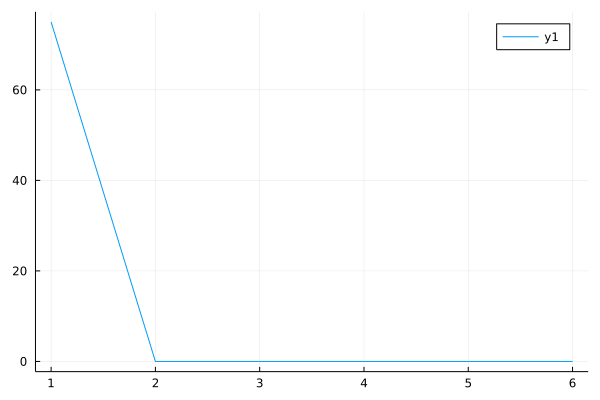

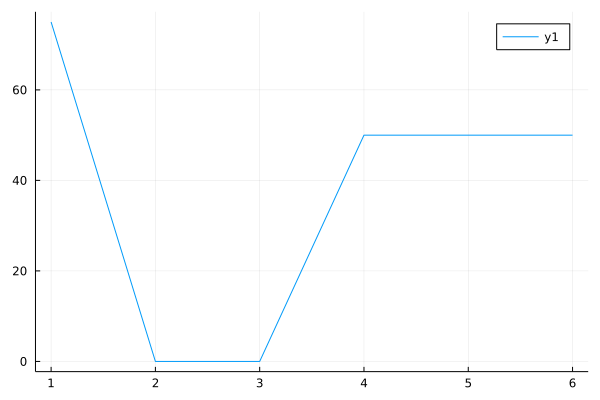

Power purchased from bilateral contracts: 75.0
Power purchased from bilateral contracts: 225.0


In [208]:
# visualization of Power purchased from bilateral contracts
x1 = Vector{Float64}()  

for b in B
    append!(x1, value.(PB[b,"w1"]))
end
PB1 = sum(value.(PB[b,"w1"]) for b in B)

x2 = Vector{Float64}()  

for b in B
    append!(x2, value.(PB[b,"w9"]))
end
PB2 = sum(value.(PB[b,"w9"]) for b in B)
display(plot(Array{Int}(1:length(x1)),x1))
display(plot(Array{Int}(1:length(x2)),x2))
println("Power purchased from bilateral contracts: ", PB1)
println("Power purchased from bilateral contracts: ", PB2)

In [197]:
objective_value(co_pv)

413821.4375